#**IndustryLab - Progetto.ipynb**

In [ ]:
#Installazione pacchetti
!pip install jupyterplot
!pip install pyod
!pip install pykafka

In [3]:
#Caricamento pacchetto
import statistics
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pylab import rcParams
from matplotlib.collections import PathCollection
from jupyterplot import ProgressPlot
from scipy.stats import iqr, zscore, shapiro, chi2
from sklearn.covariance import EllipticEnvelope
from scipy.spatial.distance import mahalanobis
from sklearn.neighbors import LocalOutlierFactor
from pyod.utils.utility import precision_n_scores
from pykafka import KafkaClient
from collections import Counter
from IPython.display import HTML
from sklearn.preprocessing import MinMaxScaler
import io
import base64
import datetime
sns.set(style="darkgrid")

/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or 

In [0]:
#Configurazione del layout
#https://stackoverflow.com/questions/21754976/ipython-notebook-arrange-plots-horizontally 

class FlowLayout(object):
    def __init__(self):
        self.sHtml =  """
        <style>
        .floating-box {
        display: inline-block;
        margin: 10px;
        border: 3px solid #888888;  
        }
        </style>
        """
    def add_plot(self, oAxes):
        Bio=io.BytesIO() 
        fig = oAxes.get_figure()
        fig.canvas.print_png(Bio) 
        sB64Img = base64.b64encode(Bio.getvalue()).decode()
        self.sHtml+= (
            '<div class="floating-box">'+ 
            '<img src="data:image/png;base64,{}\n">'.format(sB64Img)+
            '</div>')
    def PassHtmlToCell(self):
        ''' Final step - display the accumulated HTML '''
        display(HTML(self.sHtml))

oPlot = FlowLayout()

In [0]:
#Caricamento db originale
db = pd.read_csv("/content/Caso2.csv")
db.head(1)

,Banco,CodiceDaLinea,Programma,Data_ora,Data,Ora,Turno,Master,coppia_max_ciclo,picco_coppia_zero,media_coppia_zero,picco_coppia_iniziale,media_coppia_iniziale,velocita_a_regime,picco_pressione_velocita_a_regime,media_pressione_velocita_a_regime,picco_portata_velocita_a_regime,media_portata_velocita_a_regime,velicita_1,picco_pressione_velocita_1,media_pressione_velocita_1,picco_portata_velocita_1,media_portata_velocita_1,velocita_2,picco_pressione_velocita_2,media_pressione_velocita_2,picco_portata_velocita_2,media_portata_velocita_2,picco_coppia_finale,media_coppia_finale,Temperatura,n_esito,esito
0,BancoGP5,010160954163140A00000000000,18_GP5_910_CW.DBF,2016-11-09 15:43:30,09/11/2016,15:43:30,B,,0.0,0.0,0.000917,0.0,0.0,2300.0,12.209582,12.041801,1343.039795,1341.342041,140.0,1.674603,1.643796,51.519997,51.481518,500.0,0.0,0.0,0.0,0.0,0.204679,0.1438,42.196945,100,PEZZO BUONO ...


##**Data Preparation**

In [0]:
print(len(db.columns))
print(db.columns)

33
Index(['Banco', 'CodiceDaLinea', 'Programma', 'Data_ora', 'Data', 'Ora',
       'Turno', 'Master', 'coppia_max_ciclo', 'picco_coppia_zero',
       'media_coppia_zero', 'picco_coppia_iniziale', 'media_coppia_iniziale',
       'velocita_a_regime', 'picco_pressione_velocita_a_regime',
       'media_pressione_velocita_a_regime', 'picco_portata_velocita_a_regime',
       'media_portata_velocita_a_regime', 'velicita_1',
       'picco_pressione_velocita_1', 'media_pressione_velocita_1',
       'picco_portata_velocita_1', 'media_portata_velocita_1', 'velocita_2',
       'picco_pressione_velocita_2', 'media_pressione_velocita_2',
       'picco_portata_velocita_2', 'media_portata_velocita_2',
       'picco_coppia_finale', 'media_coppia_finale', 'Temperatura', 'n_esito',
       'esito'],
      dtype='object')


In [0]:
classes = {}
for i in db.columns:
  classes[i]=len(db[i].unique())

#Useless variables
useless = dict((k, v) for k, v in classes.items() if v == 1)
useless_list = [i for i in useless.keys()]
useless_list

['Banco',
 'Master',
 'picco_coppia_zero',
 'picco_coppia_iniziale',
 'media_coppia_iniziale',
 'velicita_1',
 'picco_pressione_velocita_2',
 'media_pressione_velocita_2',
 'picco_portata_velocita_2',
 'media_portata_velocita_2']

####Rimozione costanti

In [0]:
useful = set([i for i in db.columns]) - set(useless_list) - set(['Data','Ora'])
db_ = db[[i for i in useful]]

In [0]:
#Variabili finali
print("Num. variabili utili: ",len(db_.columns))
db_.columns

Num. variabili utili:  21


Index(['picco_pressione_velocita_1', 'Turno', 'picco_coppia_finale',
       'picco_portata_velocita_1', 'n_esito', 'Temperatura',
       'media_pressione_velocita_1', 'media_coppia_finale', 'Data_ora',
       'media_coppia_zero', 'media_portata_velocita_a_regime', 'velocita_2',
       'picco_pressione_velocita_a_regime', 'media_portata_velocita_1',
       'coppia_max_ciclo', 'velocita_a_regime',
       'picco_portata_velocita_a_regime', 'Programma', 'CodiceDaLinea',
       'esito', 'media_pressione_velocita_a_regime'],
      dtype='object')

In [0]:
#Order by year
db_['Data_ora'] = pd.to_datetime(db_['Data_ora'])
db_ord = db.sort_values(by='Data_ora')

####Rimozione `velocita_2`

In [0]:
#Binario

#Useless variables
binary = dict((k, v) for k, v in classes.items() if v == 2)
binary = [i for i in binary.keys()]
binary

['velocita_2']

In [0]:
db_.velocita_2.unique()

array([500., 100.])

In [0]:
print(dict(Counter(db_.velocita_2)))

{500.0: 296598, 100.0: 7}


In [0]:
#Rimozione velocita_2
db_.drop(['velocita_2'], axis='columns', inplace=True)

La variabile 'velocita_2' ha praticamente solo valori pari a 500.

In [0]:
#Caricamento db ridotto
db = pd.read_csv("/content/DbRidotto.csv")
db.drop(['Unnamed: 0'], axis='columns', inplace=True)
db.head(1)

,picco_pressione_velocita_1,Turno,picco_coppia_finale,picco_portata_velocita_1,Temperatura,media_pressione_velocita_1,media_coppia_finale,Data_ora,media_coppia_zero,media_portata_velocita_a_regime,picco_pressione_velocita_a_regime,media_portata_velocita_1,picco_portata_velocita_a_regime,Programma,esito,media_pressione_velocita_a_regime,Coefficiente
0,1.674603,B,0.204679,51.519997,42.196945,1.643796,0.1438,2016-11-09 15:43:30,0.000917,1341.342041,12.209582,51.481518,1343.039795,18_GP5_910_CW.DBF,PEZZO BUONO ...,12.041801,784.683851


In [0]:
db = pd.read_csv("/content/DbRidotto.csv")
db.drop(['Unnamed: 0'], axis='columns', inplace=True)
db.head(1)

,picco_pressione_velocita_1,Turno,picco_coppia_finale,picco_portata_velocita_1,Temperatura,media_pressione_velocita_1,media_coppia_finale,Data_ora,media_coppia_zero,media_portata_velocita_a_regime,picco_pressione_velocita_a_regime,media_portata_velocita_1,picco_portata_velocita_a_regime,Programma,esito,media_pressione_velocita_a_regime
0,1.674603,B,0.204679,51.519997,42.196945,1.643796,0.1438,2016-11-09 15:43:30,0.000917,1341.342041,12.209582,51.481518,1343.039795,18_GP5_910_CW.DBF,PEZZO BUONO ...,12.041801


##**Analisi preliminari**

###**Variabili categoriche**

In [0]:
#Numero di classi
print("Turno: ",len(db_.Turno.unique()))
print("Programma",len(db_.Programma.unique()))
print("CodiceDaLinea",len(db_.CodiceDaLinea.unique()))
print("Esito",len(db_.esito.unique()))

Turno:  9
Programma 18
CodiceDaLinea 294489
Esito 25


####Rimozione `CodiceDaLinea`

In [0]:
#Rimozione CodiceDaLinea
db_.drop(['CodiceDaLinea'], axis='columns', inplace=True)

####Analisi `Turno`

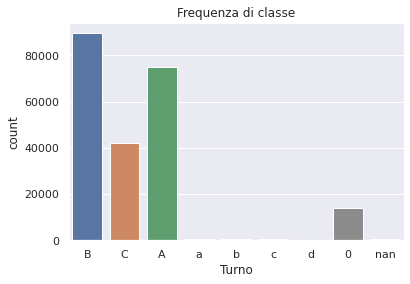

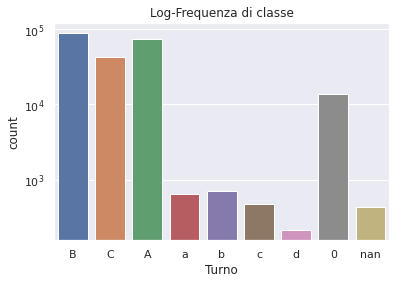

In [0]:
##Analisi Turno

#Elaborazione per plot
dbp = db
dbp.Turno = dbp.Turno.apply(str)
#dbp.Turno = dbp.Turno.replace("nan", np.nan)

plt.subplot(111)
ax1 = sns.countplot(x="Turno", data=dbp)
plt.title("Frequenza di classe")
plt.show()

plt.subplot(111)
ax = sns.countplot(x="Turno", data=dbp)
ax.set_yscale('log')
plt.title("Log-Frequenza di classe"
plt.show()

Come specificato dai fornitori del database, le classi del turno giornaliero devono essere 3, quindi vengono raggruppate:

In [0]:
import warnings
warnings.filterwarnings("ignore")
db.Turno[db.Turno=="a"] = "A"
db.Turno[db.Turno=="b"] = "B"
db.Turno[db.Turno=="c"] = "C"
db.Turno[(db.Turno == "d")|(db.Turno == "nan")|(db.Turno == '0')] = np.nan
db.Turno.unique()

array(['B', 'C', 'A', nan], dtype=object)

In [0]:
#Mostra il nome e la frequenza di ogni turno
P = pd.DataFrame.from_dict(dict(Counter(db.Turno)),orient='index').reset_index()
P.columns = ['K','V']
P.reset_index()
P_ = P.sort_values('V',ascending=False)
P_ = P_.reset_index()
P_.columns = ['Fattore','Nome','Frequenza']
#Aggiung freq relativa
P_['%'] = P_.Frequenza/len(db)
P_ = P_[['Nome','Frequenza','%']]
P_

,Nome,Frequenza,%
0,B,89631,0.401436
1,A,74958,0.335719
2,C,42214,0.189066
3,0,13992,0.062667
4,b,711,0.003184
5,a,647,0.002898
6,c,474,0.002123
7,NaN,436,0.001953
8,d,213,0.000954


####Analisi `Programma`

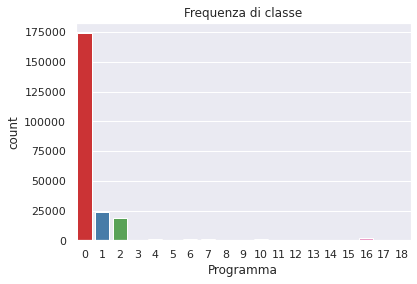

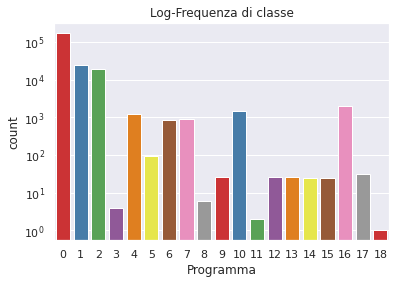

In [0]:
#Analisi Programma

#Elaborazione per plot
dbp = db
dbp.Programma = dbp.Programma.apply(str)
dbp.Programma = pd.factorize(dbp.Programma)[0]

sns.set(style="darkgrid")
plt.subplot(111)
ax1 = sns.countplot(x="Programma", data=dbp, palette="Set1")
plt.title("Frequenza di classe")
plt.show()

plt.subplot(111)
ax = sns.countplot(x="Programma", data=dbp, palette="Set1")
ax.set_yscale('log')
plt.title("Log-Frequenza di classe")
plt.show()

In [0]:
#Mostra il nome e la frequenza di ogni programma
P = pd.DataFrame.from_dict(dict(Counter(db.Programma)),orient='index').reset_index()
P.columns = ['K','V']
P.reset_index()
P_ = P.sort_values('V',ascending=False)
P_ = P_.reset_index()
P_.columns = ['Fattore','Nome','Frequenza']
#Aggiung freq relativa
P_['%'] = P_.Frequenza/len(db)
P_

,Fattore,Nome,Frequenza,%
0,0,18_GP5_910_CW.DBF,173972,0.779179
1,1,17_GP5_430_CCW.DBF,23641,0.105882
2,2,12_GP5_430B_D1.DBF,18932,0.084792
3,16,15_GP5_340_CCW.DBF,2029,0.009087
4,10,14_GP5_340_D1.DBF,1504,0.006736
5,4,13_GP5_500_CW.DBF,1234,0.005527
6,7,16_GP5_500_CCW.DBF,876,0.003923
7,6,05_GP5_340_S1.DBF,821,0.003677
8,5,058_GP5_CAMERARIDOTTA.DBF,95,0.000425
9,17,19_GP5S-CAMRID_CW.DBF,31,0.000139


####Analisi `esito`

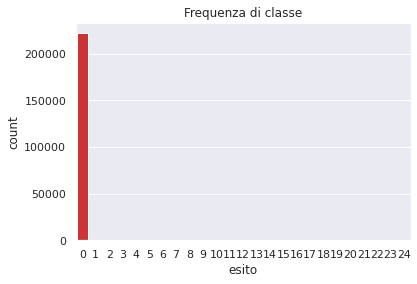

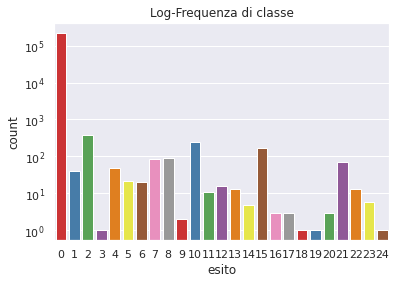

In [0]:
#Analisi Esito

#Elaborazione per plot
dbp.esito = dbp.esito.apply(str)
l1 = pd.Series(pd.factorize(dbp.esito)[1])
l2 = pd.Series(db.esito.unique())
dbp.esito = pd.factorize(dbp.esito)[0]

plt.subplot(111)
ax1 = sns.countplot(x="esito", data=dbp, palette="Set1")
plt.title("Frequenza di classe")
plt.show()

plt.subplot(111)
ax = sns.countplot(x="esito", data=dbp, palette="Set1")
ax.set_yscale('log')
plt.title("Log-Frequenza di classe")
plt.show()

In [0]:
#Mostra il nome e la frequenza di ogni esito
P = pd.DataFrame.from_dict(dict(Counter(db.esito)),orient='index').reset_index()
P.columns = ['K','V']
P.reset_index()
P_ = P.sort_values('V',ascending=False)
P_ = P_.reset_index()
P_.columns = ['Fattore','Nome','Frequenza']
#Aggiungi frequenza relativa
P_['%'] = P_.Frequenza/len(db)
P_

,Fattore,Nome,Frequenza,%
0,0,PEZZO BUONO ...,222031,0.994424
1,2,SCARTO PICCO COPPIA MAX FASE PULIZIA INIZIALE ...,373,0.001671
2,10,SCARTO PORTATA CONTROLLO VELOCITA'1 MIN MEDIA ...,241,0.001079
3,15,SCARTO COPPIA FINALE MAX MEDIA ...,171,0.000766
4,8,SCARTO PORTATA VELOCITA' A REGIME MAX PICCO ...,92,0.000412
5,7,SCARTO PRESSIONE CONTROLLO VELOCITA'1 MIN MEDI...,87,0.000390
6,21,SCARTO COPPIA MAX CICLO ...,71,0.000318
7,4,SCARTO PORTATA VELOCITA' A REGIME MIN MEDIA ...,48,0.000215
8,1,ANOMALIA AGGANCIO ...,40,0.000179
9,5,SCARTO PRESSIONE VELOCITA' A REGIME MAX PICCO ...,22,0.000099


####Rimozione `n_esito`
`n_esito` è la versione numerica di `esito

In [0]:
db.drop(['n_esito'], axis='columns', inplace=True)

###**Variabili numeriche**

In [0]:
categ = ['Turno','Programma','esito','Data_ora']
db_num = db.drop([i for i in categ], axis='columns')

In [0]:
db_num.head(1)

,picco_pressione_velocita_1,picco_coppia_finale,picco_portata_velocita_1,Temperatura,media_pressione_velocita_1,media_coppia_finale,media_portata_velocita_a_regime,picco_pressione_velocita_a_regime,media_portata_velocita_1,picco_portata_velocita_a_regime,media_pressione_velocita_a_regime,Coefficiente
0,1.674603,0.204679,51.519997,42.196945,1.643796,0.1438,1341.342041,12.209582,51.481518,1343.039795,12.041801,784.683851


####**Descrittori della pressione**

Correlazione e poi, in base alle variabili più correlate boxplot per le classi come [qui](https://seaborn.pydata.org/generated/seaborn.violinplot.html) e anche con le categoriche:
- esito
- turno

In [0]:
#Selezione delle variabili che riguardano la pressione
press = ['picco_pressione_velocita_1','media_pressione_velocita_1','picco_pressione_velocita_a_regime',
         'media_pressione_velocita_a_regime']

df_press = db[[k for k in press]]
df_press.columns = ['Picco Vel.1','Media Vel.1','Picco a regime','Media a regime']
df_press.head(1)

,Picco Vel.1,Media Vel.1,Picco a regime,Media a regime
0,1.674603,1.643796,12.209582,12.041801


In [0]:
#Valori mancanti
for k in df_press.columns:
  print(k,":",len(df_press[df_press[k].isnull()]))

Picco Vel.1 : 1
Media Vel.1 : 1
Picco a regime : 1
Media a regime : 1


In [0]:
missing = df_press[df_press.isnull().any(axis=1)]
missing.index.tolist()

[223275]

In [0]:
#Rimozione dell'osservazione
db.drop(index=223275,inplace=True)
df_press.drop(index=223275,inplace=True)
db_num.drop(index=223275,inplace=True)
#db.to_csv("/content/DbRidotto.csv")


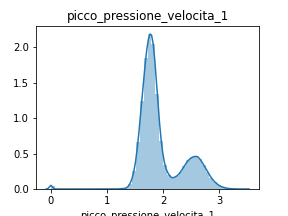
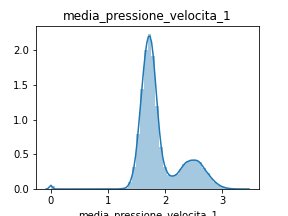
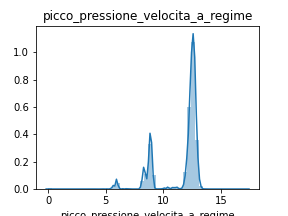
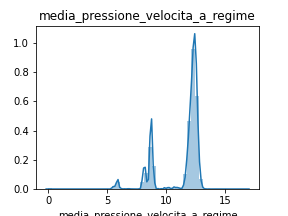

In [0]:
#Distribuzione

for i in press: 
    fig, ax = plt.subplots(1, 1, figsize=(4,3))                      
    sns.distplot(db[i])
    plt.title(str(i)) 
    oPlot.add_plot(ax) 
    plt.close() 
oPlot.PassHtmlToCell()

In [0]:
#Grouped dataframe
#https://stackoverflow.com/questions/57137902/split-violin-plot-for-two-variables-with-seaborn

vel1 = df_press[['Picco Vel.1','Media Vel.1']]
vel1['Tipo'] = "Vel. 1"
regime = df_press[['Picco a regime','Media a regime']]
regime['Tipo'] = "A regime"
grouped = pd.DataFrame()
grouped['Picco Pressione'] = pd.Series(vel1['Picco Vel.1'].append(regime['Picco a regime']))
grouped['Media Pressione'] = pd.Series(vel1['Media Vel.1'].append(regime['Media a regime']))
grouped['Tipo'] = pd.Series(vel1['Tipo'].append(regime['Tipo']))

#Grouped split dataframe
v = grouped[grouped.Tipo=="Vel. 1"]
r = grouped[grouped.Tipo=="A regime"]
v1 = pd.DataFrame({'Picco': v['Picco Pressione'],
                   'Media': v['Media Pressione']})
r1 = pd.DataFrame({'Picco': r['Picco Pressione'],
                   'Media': r['Media Pressione']})

#Pivoting
v1 = v1.melt().assign(x='Velocità 1')
r1 = r1.melt().assign(x="A regime")
v1.columns = ['Misura','Pressione','x'] 
r1.columns = ['Misura','Pressione','x']

#Final df
g = r1.append(v1)
g.columns = ['Misura','Pressione','x']

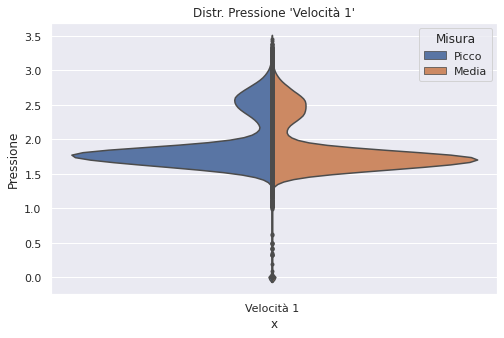

In [0]:
#Violinplot Velocità 1
rcParams['figure.figsize'] = 8, 5


ax = sns.violinplot(data=v1, x='x', y='Pressione', 
               hue='Misura', split=True, inner="point")

plt.title("Distr. Pressione 'Velocità 1'")
plt.show()


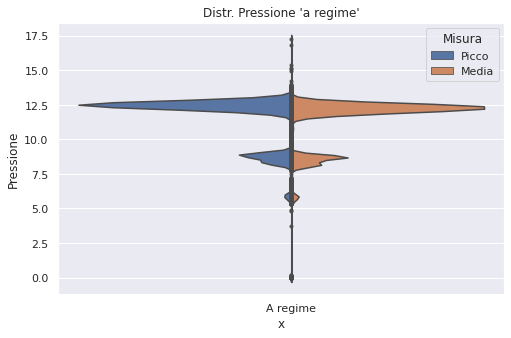

In [0]:
#Violinplot A regime
rcParams['figure.figsize'] = 8, 5


ax = sns.violinplot(data=r1, x='x', y='Pressione', 
               hue='Misura', split=True, inner="point")

plt.title("Distr. Pressione 'a regime'")
plt.show()


Text(0.5, 1.0, 'Distribuzioni a confronto')

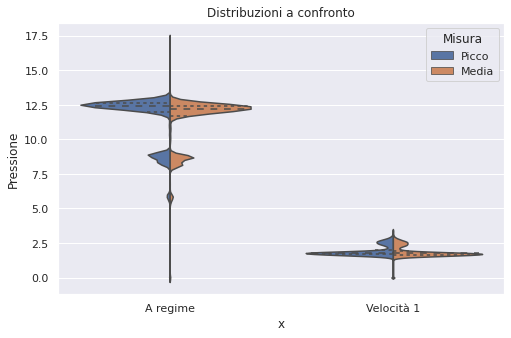

In [0]:
#Violinplot

rcParams['figure.figsize'] = 8, 5

sns.violinplot(data=g, x='x', y='Pressione', 
               hue='Misura', split=True, inner='quart')
plt.title("Distribuzioni a confronto")

####**Descrittori della portata**

In [0]:
#Selezione delle variabili che riguardano la portata
port = ['media_portata_velocita_1','media_portata_velocita_a_regime','picco_portata_velocita_1',
        'picco_portata_velocita_a_regime']

df_port = db[[k for k in port]]
df_port.columns = ['Media Vel.1','Media a regime','Picco Vel.1','Picco a regime']
df_port.head(1)

,Media Vel.1,Media a regime,Picco Vel.1,Picco a regime
0,51.481518,1341.342041,51.519997,1343.039795


In [0]:
#Valori mancanti
for k in df_port.columns:
  print(k,":",len(df_port[df_port[k].isnull()]))

Media Vel.1 : 0
Media a regime : 0
Picco Vel.1 : 0
Picco a regime : 0



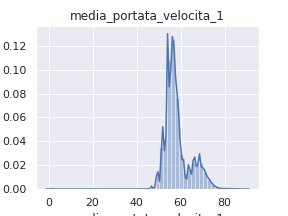
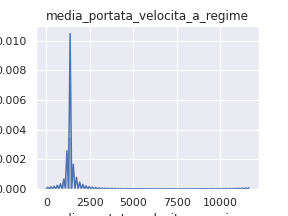
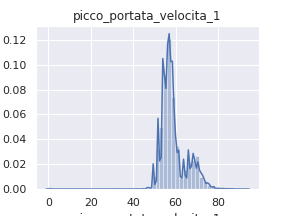
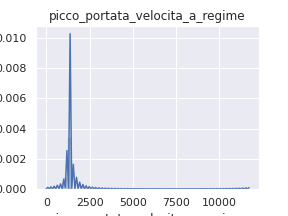

In [0]:
#Distribuzione

for i in port: 
    fig, ax = plt.subplots(1, 1, figsize=(4,3))                      
    sns.distplot(db[i])
    plt.title(str(i)) 
    oPlot.add_plot(ax) 
    plt.close() 
oPlot.PassHtmlToCell()

In [0]:
#Grouped dataframe
vel1 = df_port[['Picco Vel.1','Media Vel.1']]
vel1['Tipo'] = "Vel. 1"
regime = df_port[['Picco a regime','Media a regime']]
regime['Tipo'] = "A regime"
grouped = pd.DataFrame()
grouped['Picco Portata'] = pd.Series(vel1['Picco Vel.1'].append(regime['Picco a regime']))
grouped['Media Portata'] = pd.Series(vel1['Media Vel.1'].append(regime['Media a regime']))
grouped['Tipo'] = pd.Series(vel1['Tipo'].append(regime['Tipo']))

#Grouped split dataframe
v = grouped[grouped.Tipo=="Vel. 1"]
r = grouped[grouped.Tipo=="A regime"]
v1 = pd.DataFrame({'Picco': v['Picco Portata'],
                   'Media': v['Media Portata']})
r1 = pd.DataFrame({'Picco': r['Picco Portata'],
                   'Media': r['Media Portata']})

#Pivoting
v1 = v1.melt().assign(x='Velocità 1')
r1 = r1.melt().assign(x="A regime")
v1.columns = ['Misura','Portata','x'] 
r1.columns = ['Misura','Portata','x']

#Final df
g = r1.append(v1)
g.columns = ['Misura','Portata','x']

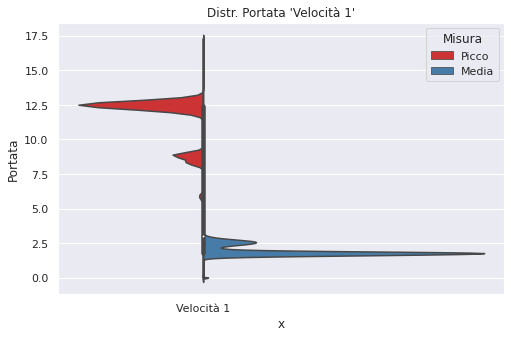

In [0]:
#Violinplot Velocità 1
rcParams['figure.figsize'] = 8, 5


ax = sns.violinplot(data=v1, x='x', y='Portata', 
               hue='Misura', split=True, palette="Set1")

plt.title("Distr. Portata 'Velocità 1'")
plt.show()


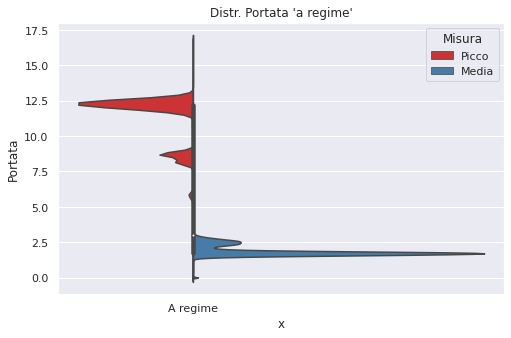

In [0]:
#Violinplot A regime
rcParams['figure.figsize'] = 8, 5


ax = sns.violinplot(data=r1, x='x', y='Portata', 
               hue='Misura', split=True, palette="Set1")

plt.title("Distr. Portata 'a regime'")
plt.show()

Text(0.5, 1.0, 'Distribuzioni a confronto')

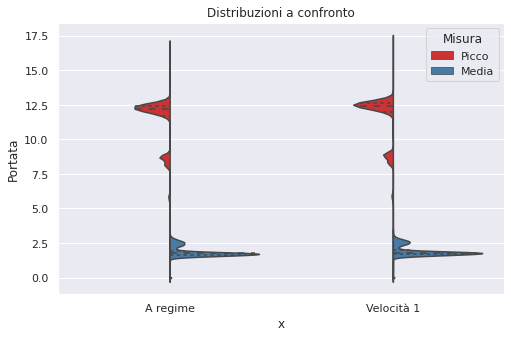

In [0]:
#Violinplot

rcParams['figure.figsize'] = 8, 5

sns.violinplot(data=g, x='x', y='Portata', 
               hue='Misura', split=True, inner='quart', palette="Set1")
plt.title("Distribuzioni a confronto")

####**Altre variabili**

In [0]:
altre = set(db_num.columns)-set(press)-set(port)
altre

{'Temperatura',
 'coppia_max_ciclo',
 'media_coppia_finale',
 'media_coppia_zero',
 'picco_coppia_finale',
 'velocita_a_regime'}

In [0]:
#Valori mancanti
for k in altre:
  print(k,":",len(db_num[db_num[k].isnull()]))

media_coppia_zero : 0
media_coppia_finale : 0
coppia_max_ciclo : 0
velocita_a_regime : 0
picco_coppia_finale : 0
Temperatura : 0


####`coppia_max_ciclo`

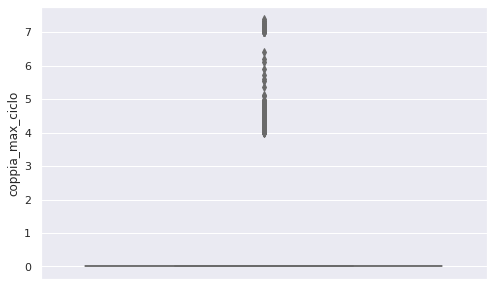

In [0]:
sns.boxplot(data=db_num, y='coppia_max_ciclo',palette="Set3")

In [0]:
#Quantità di 0
print("% valori nulli in coppia_max_ciclo:",len(db_num[db_num['coppia_max_ciclo']==0])/len(db_num))
print("Num valori non nulli:",len(db_num[db_num['coppia_max_ciclo']!=0]),"su",len(db_num))

% valori nulli in coppia_max_ciclo: 0.9979666421827693
Num valori non nulli: 454 su 223276


In [0]:
#Rimozione 
db.drop(['coppia_max_ciclo'], axis='columns', inplace=True)
db_num.drop(['coppia_max_ciclo'], axis='columns', inplace=True)

####`media_coppia_finale`

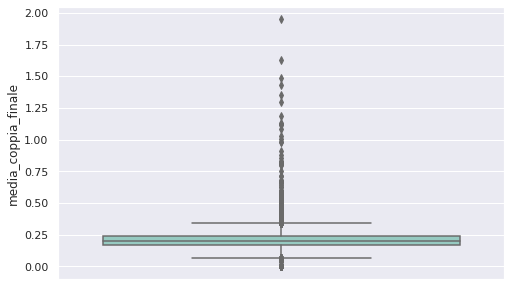

In [0]:
sns.boxplot(data=db_num, y='media_coppia_finale',palette="Set3")

####`'media_coppia_zero'`

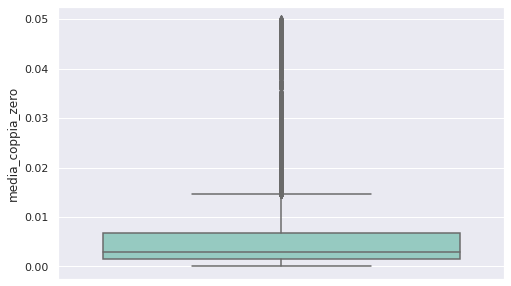

In [0]:
sns.boxplot(data=db_num, y='media_coppia_zero',palette="Set3")

La variabile viene rimossa perché non ritenuta significativa ai fini dell'analisi di correlazione dai fornitori del database.

In [0]:
db.drop(['media_coppia_zero'], axis='columns', inplace=True)

####`picco_coppia_finale`

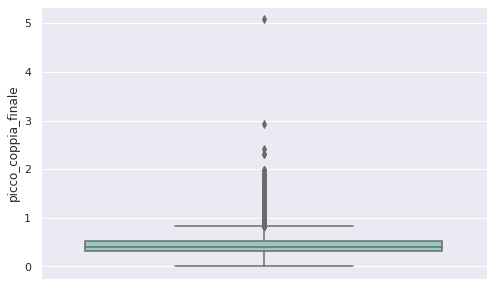

In [0]:
sns.boxplot(data=db_num, y='picco_coppia_finale',palette="Set3")

####`velocita_a_regime`


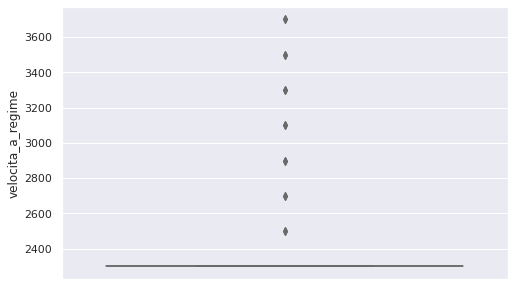

In [0]:
sns.boxplot(data=db_num, y='velocita_a_regime',palette="Set3")

In [0]:
#Valori unici
db_num.velocita_a_regime.unique()

array([2300., 2500., 2700., 2900., 3100., 3300., 3500., 3700.])

In [0]:
#Valori di frequenza
V = pd.DataFrame.from_dict(dict(Counter(db_num.velocita_a_regime)),orient='index').reset_index()
V.columns = ['Valore','Frequenza']
V['%'] = V.Frequenza/len(db_num)
V

,Valore,Frequenza,%
0,2300.0,223261,0.999937
1,2500.0,2,0.000009
2,2700.0,2,0.000009
3,2900.0,2,0.000009
4,3100.0,2,0.000009
5,3300.0,2,0.000009
6,3500.0,2,0.000009
7,3700.0,2,0.000009


In [0]:
#Rimozione 
db.drop(['velocita_a_regime'], axis='columns', inplace=True)
db_num.drop(['velocita_a_regime'], axis='columns', inplace=True)

####`Temperatura`

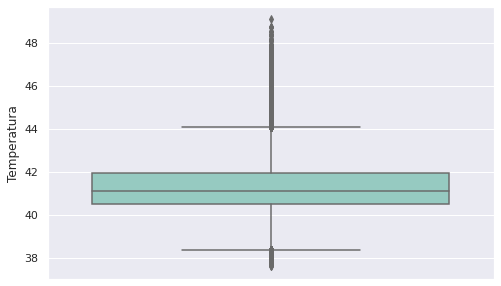

In [0]:
sns.boxplot(data=db_num, y='Temperatura',palette="Set3")

In [0]:
#Range temperatura:
print("Temperatura minima:",db.Temperatura.min())
print("Temperatura massima:",db.Temperatura.max())
print("Temperatura media:",db.Temperatura.mean())

Temperatura minima: 37.61205673217773
Temperatura massima: 49.10082626342773
Temperatura media: 41.232832188006675


###**Correlazione fra variabili numeriche**

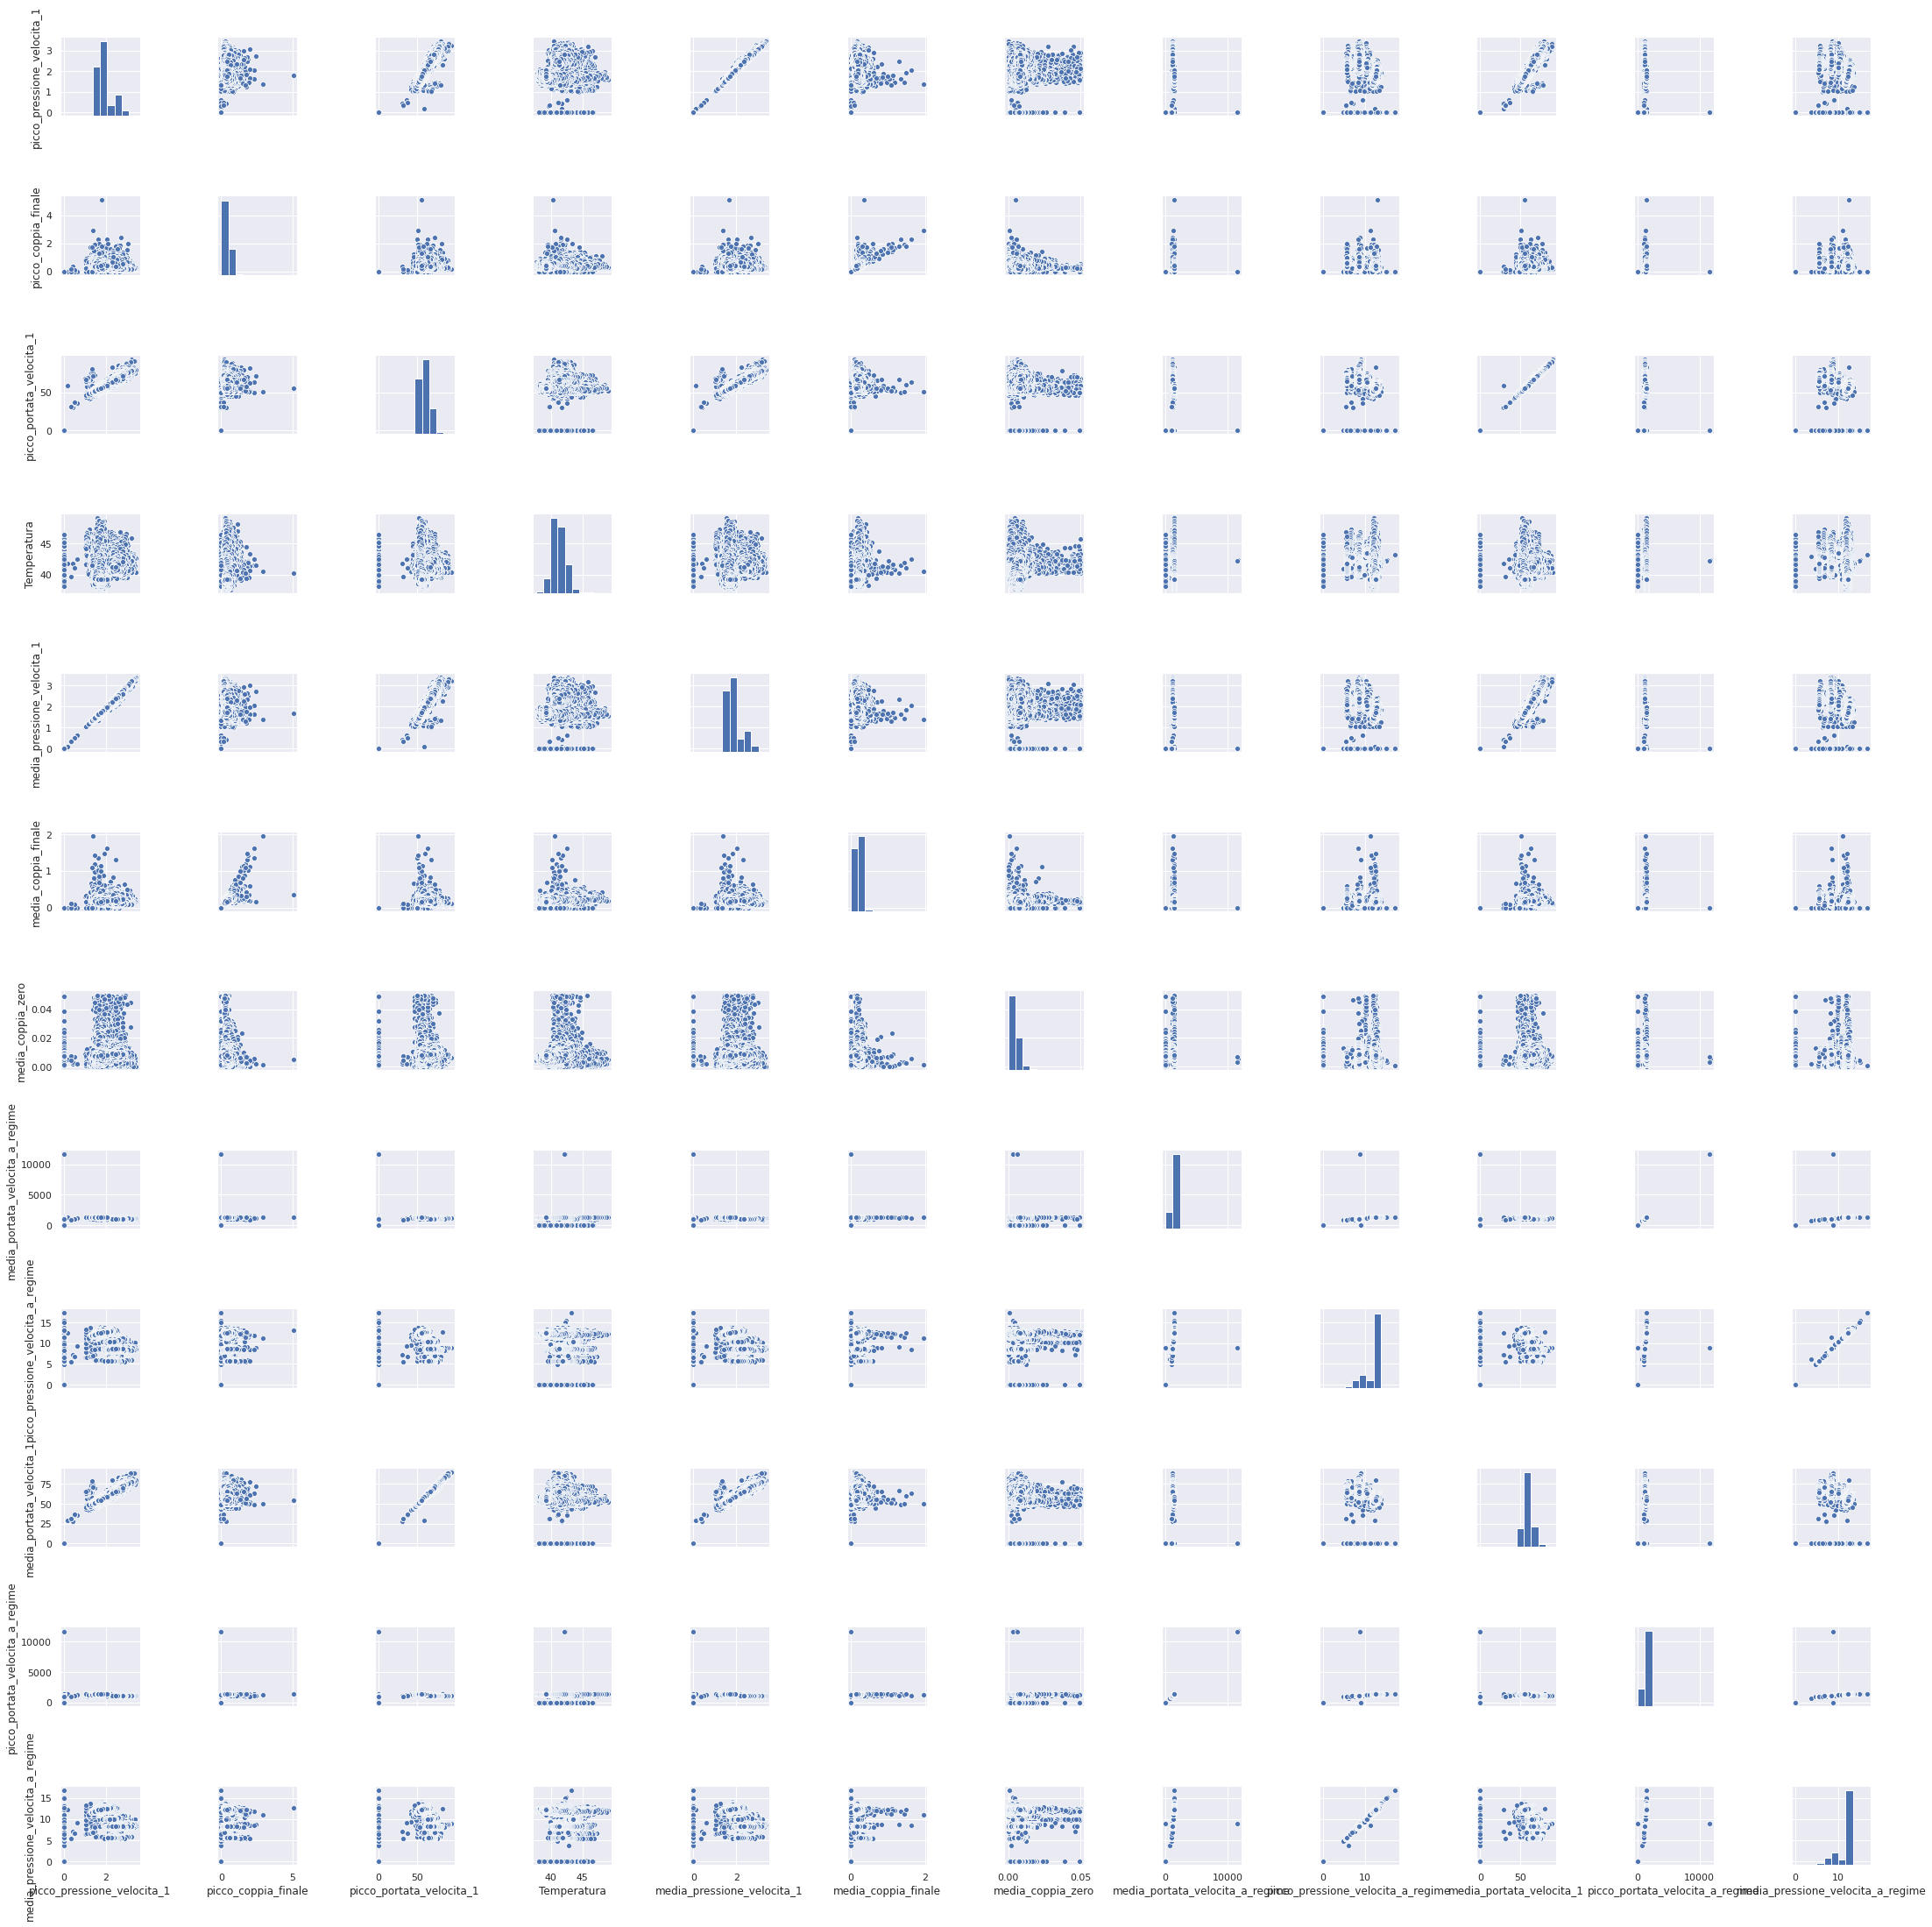

In [0]:
#Correlogramma
sns.pairplot(db_num)

In [0]:
#Correlation matrix
db_num.columns = ['Picco Pressione Vel.1', 'Picco coppia Fin.',
       'Picco Portata Vel.1', 'Temp.', 'Media Pressione Vel.1',
       'Media coppia Fin.', 'Media coppia 0',
       'Media Portata a reg.', 'Picco Pressione a reg.',
       'Media Portata Vel.1', 'Picco portata a reg.',
       'Media Pressione a reg.']
c = db_num.corr()
c.round(decimals=3)

,Picco Pressione Vel.1,Picco coppia Fin.,Picco Portata Vel.1,Temp.,Media Pressione Vel.1,Media coppia Fin.,Media coppia 0,Media Portata a reg.,Picco Pressione a reg.,Media Portata Vel.1,Picco portata a reg.,Media Pressione a reg.
Picco Pressione Vel.1,1.000,-0.040,0.903,0.076,0.997,-0.134,-0.015,-0.502,-0.674,0.909,-0.501,-0.671
Picco coppia Fin.,-0.040,1.000,0.027,0.191,-0.058,0.833,-0.081,0.060,0.045,0.028,0.063,0.036
Picco Portata Vel.1,0.903,0.027,1.000,0.044,0.899,-0.005,0.047,-0.344,-0.532,0.998,-0.339,-0.531
Temp.,0.076,0.191,0.044,1.000,0.072,0.126,-0.086,-0.104,-0.115,0.044,-0.104,-0.119
Media Pressione Vel.1,0.997,-0.058,0.899,0.072,1.000,-0.160,-0.030,-0.499,-0.672,0.905,-0.498,-0.666
Media coppia Fin.,-0.134,0.833,-0.005,0.126,-0.160,1.000,-0.006,0.164,0.165,-0.008,0.171,0.150
Media coppia 0,-0.015,-0.081,0.047,-0.086,-0.030,-0.006,1.000,-0.016,-0.007,0.045,-0.011,-0.017
Media Portata a reg.,-0.502,0.060,-0.344,-0.104,-0.499,0.164,-0.016,1.000,0.912,-0.340,1.000,0.913
Picco Pressione a reg.,-0.674,0.045,-0.532,-0.115,-0.672,0.165,-0.007,0.912,1.000,-0.529,0.911,0.999
Media Portata Vel.1,0.909,0.028,0.998,0.044,0.905,-0.008,0.045,-0.340,-0.529,1.000,-0.335,-0.529


In [0]:
##Estrai maggiori collinearità:
#Si contano le collinearità superiori al 50% per ogni variabile

def coll(col):
  count = len(c[abs(c[col])>=0.5])-1
  m = (sum(abs(c[col]))-1)/(len(c[col])-1)
  return count, m

In [0]:
collinearità = []
nome = []
media = []

for i in c.index:
  nome.append(i)
  count,m = coll(i)
  collinearità.append(count)
  media.append(m)

coll_df = pd.DataFrame({"Variabile":nome,
                        "Collinearità":collinearità,
                        "|Media|": media})

coll_df = coll_df.sort_values('|Media|',ascending=False)
coll_df

,Variabile,Collinearità,|Media|
8,Picco Pressione a reg.,7,0.505604
11,Media Pressione a reg.,7,0.503754
4,Media Pressione Vel.1,5,0.495897
0,Picco Pressione Vel.1,7,0.492804
7,Media Portata a reg.,4,0.441109
10,Picco portata a reg.,4,0.440503
2,Picco Portata Vel.1,5,0.424498
9,Media Portata Vel.1,5,0.424377
5,Media coppia Fin.,1,0.174647
1,Picco coppia Fin.,1,0.132856


Le variabili più collegate sono quelle legate rispettivamente alla `velocità1` e `velocità a regime`, per cui si calcolano le matrici di correlazione per le due grandezze. Inoltre, in qualche caso le variabili sono correlate ($\text{corr}>0.5$) anche se riferite a velocità diverse, ma alla stessa grandezza:
- pressione
- portata

In [0]:
#Correlazione fra variabili di velocità 1
vel1 = ['picco_pressione_velocita_1', 'media_pressione_velocita_1','picco_portata_velocita_1',
       'media_portata_velocita_1']
df_vel1 =  db[[k for k in vel1]]
df_vel1.columns = ['Picco pressione Vel.1', 'Media pressione Vel.1','Picco portata Vel.1',
       'Media portata Vel.1']
c = df_vel1.corr()
c.round(decimals=3)

,Picco pressione Vel.1,Media pressione Vel.1,Picco portata Vel.1,Media portata Vel.1
Picco pressione Vel.1,1.000,0.997,0.903,0.909
Media pressione Vel.1,0.997,1.000,0.899,0.905
Picco portata Vel.1,0.903,0.899,1.000,0.998
Media portata Vel.1,0.909,0.905,0.998,1.000


In [0]:
db.columns

Index(['picco_pressione_velocita_1', 'Turno', 'picco_coppia_finale',
       'picco_portata_velocita_1', 'Temperatura', 'media_pressione_velocita_1',
       'media_coppia_finale', 'Data_ora', 'media_coppia_zero',
       'media_portata_velocita_a_regime', 'picco_pressione_velocita_a_regime',
       'media_portata_velocita_1', 'picco_portata_velocita_a_regime',
       'Programma', 'esito', 'media_pressione_velocita_a_regime'],
      dtype='object')

In [0]:
#Correlazione fra variabili di velocità a regime
reg = ['media_portata_velocita_a_regime', 'picco_portata_velocita_a_regime','media_pressione_velocita_a_regime',
       'picco_pressione_velocita_a_regime']
df_reg =  db[[k for k in reg]]
df_reg.columns = ['Media portata a reg.', 'Picco portata a reg.','Media pressione a reg.',
       'Picco pressione a reg.']
c = df_reg.corr()
c.round(decimals=3)

,Media portata a reg.,Picco portata a reg.,Media pressione a reg.,Picco pressione a reg.
Media portata a reg.,1.000,1.000,0.913,0.912
Picco portata a reg.,1.000,1.000,0.911,0.911
Media pressione a reg.,0.913,0.911,1.000,0.999
Picco pressione a reg.,0.912,0.911,0.999,1.000


In [0]:
#Correlazione fra variabili di pressione
c = df_press.corr()
c.round(decimals=3)

,Picco Vel.1,Media Vel.1,Picco a regime,Media a regime
Picco Vel.1,1.000,0.997,-0.674,-0.671
Media Vel.1,0.997,1.000,-0.672,-0.666
Picco a regime,-0.674,-0.672,1.000,0.999
Media a regime,-0.671,-0.666,0.999,1.000


In [0]:
#Correlazione fra variabili di pressione
c = df_port.corr()
c.round(decimals=3)

,Media Vel.1,Media a regime,Picco Vel.1,Picco a regime
Media Vel.1,1.000,-0.340,0.998,-0.335
Media a regime,-0.340,1.000,-0.344,1.000
Picco Vel.1,0.998,-0.344,1.000,-0.339
Picco a regime,-0.335,1.000,-0.339,1.000


##**Coefficiente di leakage**

$$Q\downarrow GP=Q\downarrow GP_{\text{Teo}}-\alpha\bullet P\downarrow\text{out}$$

$$\text{Media portata vel. 1 (140rpm)}=\text{Media portata a regime (2300rpm)}-\text{leakage coeff}\bullet\text{Media pressione vel. 1 (140rpm)}$$
$$$$
$$\text{leakage coeff}=\frac{\text{Media portata a regime}-\text{Media portata vel. 1}}{\text{Media pressione vel. 1}}$$
$$$$
The leakage coefficient (in [(l/h)/bar]) is a performance index of the GP5, proportional to internal clearances, and represents the sensitivity of the pump to pressure changes.
If the flow coefficient is small, the pump flow rate is less affected by the outlet pressure.
The GP5 production can be classified in “leakage coefficient classes” (groups of pumps that share the same leakage coefficient). 


**La variabile `Programma` raccoglie le classi di GP5** - tipi di pompe - **che condividono lo stesso coefficiente di leakage**.

In [0]:
#È legato quindi alle classi della variabile 'Programma'
db.Programma.unique()

array(['18_GP5_910_CW.DBF', '17_GP5_430_CCW.DBF', '12_GP5_430B_D1.DBF',
       '08_GP5_910_D1.DBF', '13_GP5_500_CW.DBF',
       '058_GP5_CAMERARIDOTTA.DBF', '05_GP5_340_S1.DBF',
       '16_GP5_500_CCW.DBF', '01_GP5_430_S1.DBF',
       '01_MASTER1_D1_MASTER.DBF', '14_GP5_340_D1.DBF',
       '04_GP5_500_D1.DBF', '03_MASTER3_D1_MASTER.DBF',
       '04_MASTER1_S1_MASTER.DBF', '05_MASTER2_S1_MASTER.DBF',
       '06_MASTER3_S1_MASTER.DBF', '15_GP5_340_CCW.DBF',
       '19_GP5S-CAMRID_CW.DBF'], dtype=object)

In [0]:
#Creazione coeff di leakage
db['Coefficiente'] = (db["media_portata_velocita_a_regime"]-db['media_portata_velocita_1'])/db['media_pressione_velocita_1']
db.Coefficiente

0         784.683851
1         652.002355
2         816.794698
3         730.357626
4         640.272491
             ...    
223270    777.570350
223271    801.590644
223272    757.078621
223273    733.520011
223274    767.854558
Name: Coefficiente, Length: 223275, dtype: float64

In [0]:
#Controlla presenza di valori non calcolati
db[db['Coefficiente'].isna()][['Coefficiente',"media_portata_velocita_a_regime",'media_portata_velocita_1','media_pressione_velocita_1']]

,Coefficiente,media_portata_velocita_a_regime,media_portata_velocita_1,media_pressione_velocita_1
1553,NaN,0.0,0.0,0.0
1904,NaN,0.0,0.0,0.0
2196,NaN,0.0,0.0,0.0
2201,NaN,0.0,0.0,0.0
2220,NaN,0.0,0.0,0.0
...,...,...,...,...
219799,NaN,0.0,0.0,0.0
221276,NaN,0.0,0.0,0.0
221686,NaN,0.0,0.0,0.0
221948,NaN,0.0,0.0,0.0


In [0]:
len(db[db['Coefficiente'].isna()])/len(db)

0.002167730377337364

In [0]:
#Rimozione valori nulli
missing_coeff = db[db['Coefficiente'].isna()].index.tolist()
db.drop(index=[i for i in missing_coeff],inplace=True)
#Stampa nuova cardinalità (originaria 223275)
len(db)

222791

Text(0.5, 1.0, 'Distribuzione coefficiente')

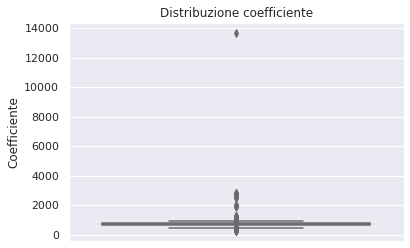

In [0]:
sns.boxplot(data=db, y='Coefficiente',palette="Set3")
plt.title("Distribuzione coefficiente")

Text(0.5, 1.0, 'Distribuzione logaritmica')

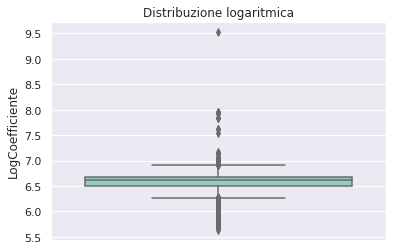

In [0]:
#Distribuzione logaritmica
sns.boxplot(data=db, y=np.log(db['Coefficiente']),palette="Set3")
plt.ylabel("LogCoefficiente")
plt.title("Distribuzione logaritmica")

In [0]:
print("Minimo coefficiente:",db.Coefficiente.min())
print("Massimo coefficiente:",db.Coefficiente.max())
print("Media coefficiente:",db.Coefficiente.mean())

Minimo coefficiente: 280.67315446062304
Massimo coefficiente: inf
Media coefficiente: inf


In [0]:
#Controlla presenza di valori "inf"
infcond = []
for i in db.Coefficiente:
  infcond.append(np.isinf(i))
True in infcond

True

In [0]:
infdb = pd.DataFrame({'Coeff':db.Coefficiente,
                      'Infinite': infcond,
                      'Portata regime': db.media_portata_velocita_a_regime,
                      'Portata vel1': db.media_portata_velocita_1,
                      'Pressione vel1': db.media_pressione_velocita_1})
infdb = infdb[infdb.Infinite==True]
infdb

,Coeff,Infinite,Portata regime,Portata vel1,Pressione vel1
2960,inf,True,1158.127930,0.0,0.0
3543,inf,True,1430.418579,0.0,0.0
5198,inf,True,6.589871,0.0,0.0
7169,inf,True,1150.740479,0.0,0.0
7276,inf,True,1148.646606,0.0,0.0
...,...,...,...,...,...
201371,inf,True,1129.248047,0.0,0.0
202266,inf,True,946.944092,0.0,0.0
209898,inf,True,960.691345,0.0,0.0
209899,inf,True,959.909790,0.0,0.0


In [0]:
#Rimozione valori nulli
inflist = infdb.index.tolist()
db.drop(index=[i for i in inflist],inplace=True)
#Stampa nuova cardinalità (precedentemente 222791)
len(db)

222559

In [0]:
#Descrizione del coefficiente
pd.DataFrame(db.Coefficiente.describe())

,Coefficiente
count,222559.000000
mean,689.496473
std,150.315383
min,280.673154
25%,665.934306
50%,740.750274
75%,785.466871
max,13677.559464


In [0]:
#Esporta csv
db.to_csv("/content/DbRidotto.csv")

Si mostra la distribuzione raggruppata per `programma`:

Text(0.5, 1.0, 'Distribuzione per programma')

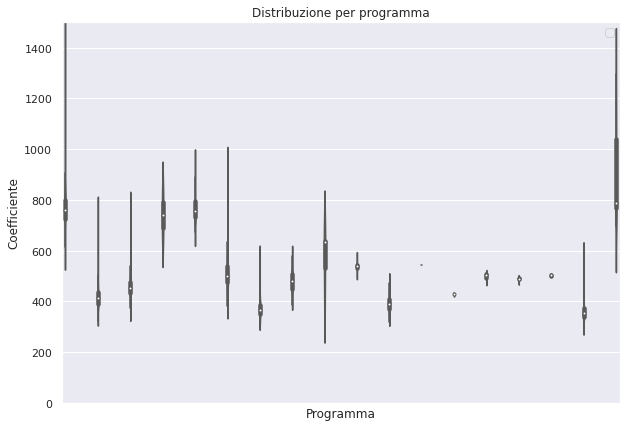

In [0]:
rcParams['figure.figsize'] = 10, 7
sns.violinplot(x="Programma", y="Coefficiente", hue="Programma",palette="Set2",data=db)
plt.ylabel("Coefficiente")
plt.xticks([])
plt.ylim(0, 1500)
plt.legend('')
plt.title("Distribuzione per programma")

Si mostra ora la correlazione rispetto alle altre variabili numeriche:

In [0]:
var = set(db.columns)-set(["media_portata_velocita_a_regime",'media_portata_velocita_1','media_pressione_velocita_1'])-set(['Data_ora','Programma','Turno','esito'])
d =  db[[k for k in var]]
c = d.corr()
print("Correlazioni rispetto a 'Coefficiente':")
d1 = pd.DataFrame(c.Coefficiente)
d1 = d1.iloc[(-np.abs(d1['Coefficiente'].values)).argsort()]
d1.iloc[1:]

Correlazioni rispetto a 'Coefficiente':


,Coefficiente
picco_pressione_velocita_1,-0.966668
picco_portata_velocita_1,-0.893068
picco_pressione_velocita_a_regime,0.859339
picco_portata_velocita_a_regime,0.856679
media_pressione_velocita_a_regime,0.855551
media_coppia_finale,0.188447
Temperatura,-0.090544
picco_coppia_finale,0.068344
media_coppia_zero,0.016420


La variabile `picco_portata_velocità_a_regime` è perfettamente positivamente correlata con la variabile `media_portata_velocità_a_regime` con cui il coefficiente è stato generato.

Si mostra ora l'andamento della serie storica nel tempo:

In [0]:
db["Data_ora"]=pd.to_datetime(db["Data_ora"])
pd.DataFrame(db["Data_ora"].describe())

,Data_ora
count,222559
unique,222559
top,2018-10-17 18:33:35
freq,1
first,2016-11-09 15:43:30
last,2019-10-04 19:49:47


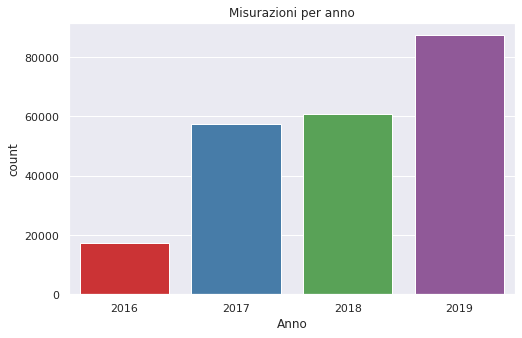

In [0]:
def anno(x):
  date = datetime.datetime.strptime(str(x), "%Y-%m-%d  %H:%M:%S")
  return date.year

def mese(x):
  date = datetime.datetime.strptime(str(x), "%Y-%m-%d  %H:%M:%S")
  return date.month

def giorno(x):
  date = datetime.datetime.strptime(str(x), "%Y-%m-%d  %H:%M:%S")
  return date.day

#Estrai anno
db['Anno'] = db.Data_ora.apply(anno)
#Distribuzione anni
rcParams['figure.figsize'] = 8, 5
sns.countplot(x="Anno", data=db, palette="Set1")
plt.title("Misurazioni per anno")
plt.show()

Text(0.5, 1.0, 'Distribuzione per anno')

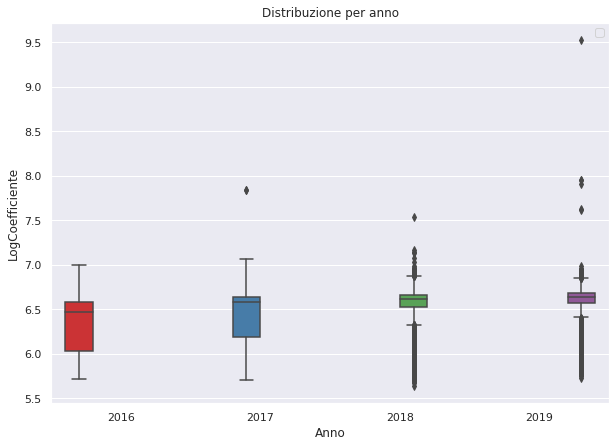

In [0]:
#Distribuzione coefficiente per anno
sns.boxplot(x="Anno", y=np.log(db["Coefficiente"]), hue="Anno",palette="Set1",data=db)
plt.ylabel("LogCoefficiente")
plt.legend('')
plt.title("Distribuzione per anno")


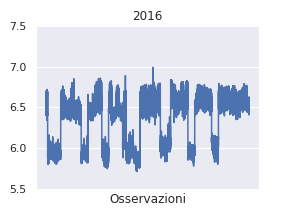
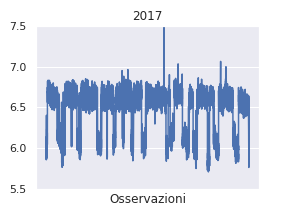
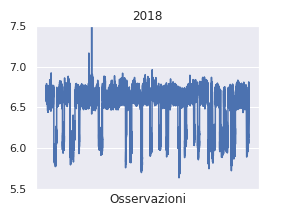
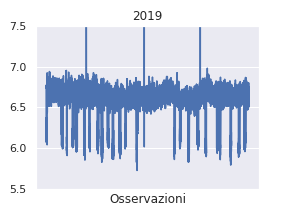

In [0]:
#Serie storiche in base all'anno
for i in db.Anno.unique(): 
    fig, ax = plt.subplots(1, 1, figsize=(4,3))                      
    plt.plot(range(len(db[db.Anno == i])), np.log(db[db.Anno == i]["Coefficiente"]))
    plt.ylim(5.5, 7.5)
    plt.xlabel("Osservazioni")
    plt.xticks([])
    plt.title(str(i)) 
    oPlot.add_plot(ax) 
    plt.close() 
oPlot.PassHtmlToCell()

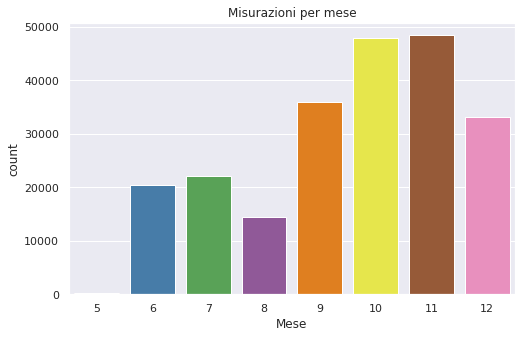

In [0]:
#Estrai mese
db['Mese'] = db.Data_ora.apply(mese)
#Distribuzione mesi
rcParams['figure.figsize'] = 8, 5
sns.countplot(x="Mese", data=db, palette="Set1")
plt.title("Misurazioni per mese")
plt.show()

Le misurazioni non state prese con coerenza cronologica.

In [0]:
#Si individua l'ordine con cui i gruppi vengono misurati (range di indici)
for k in db.Programma.unique():
  lista = db.Programma[db.Programma==k].index.tolist()
  print(k,":",lista[0],"-",lista[len(lista)-1])

18_GP5_910_CW.DBF : 0 - 222558
17_GP5_430_CCW.DBF : 126 - 218458
12_GP5_430B_D1.DBF : 3515 - 221054
08_GP5_910_D1.DBF : 3517 - 63787
058_GP5_CAMERARIDOTTA.DBF : 5912 - 68022
13_GP5_500_CW.DBF : 6453 - 174760
05_GP5_340_S1.DBF : 7329 - 34468
16_GP5_500_CCW.DBF : 10214 - 83290
01_GP5_430_S1.DBF : 14440 - 47966
01_MASTER1_D1_MASTER.DBF : 21507 - 57546
14_GP5_340_D1.DBF : 21524 - 210265
04_GP5_500_D1.DBF : 47967 - 47967
03_MASTER3_D1_MASTER.DBF : 57547 - 57572
04_MASTER1_S1_MASTER.DBF : 57573 - 57598
05_MASTER2_S1_MASTER.DBF : 57599 - 57623
06_MASTER3_S1_MASTER.DBF : 57624 - 57648
15_GP5_340_CCW.DBF : 62863 - 174472
19_GP5S-CAMRID_CW.DBF : 87408 - 218189



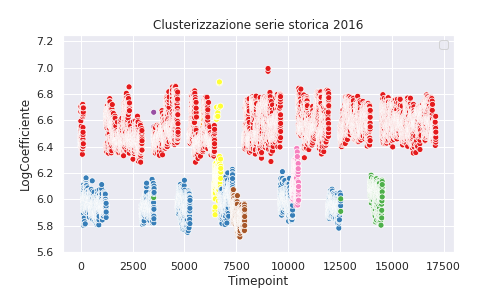
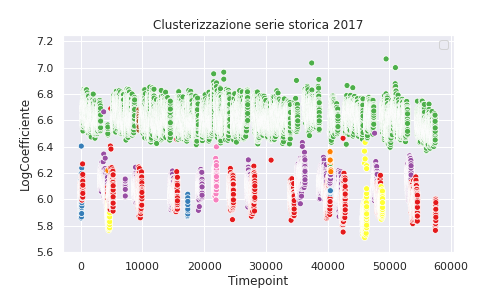
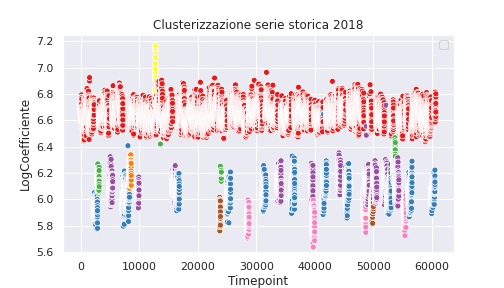
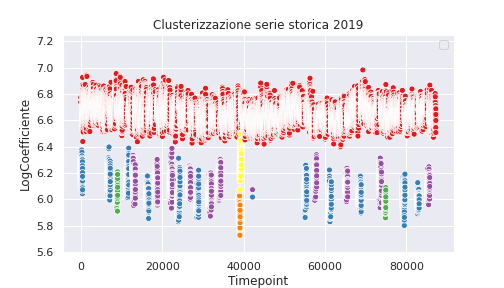

In [0]:
#Clusterizzazione della serie storica in base all'anno
for i in db.Anno.unique(): 
    fig, ax = plt.subplots(1, 1, figsize=(7,4))                      
    sns.scatterplot(x=range(len(db[db.Anno == i])), y=np.log(db[db.Anno == i]["Coefficiente"]),hue=db[db.Anno==i]['Programma'],palette="Set1")
    plt.legend('')
    plt.ylabel('LogCoefficiente')
    plt.ylim(5.6, 7.25)
    plt.xlabel('Timepoint')
    plt.title("Clusterizzazione serie storica "+str(i))
    oPlot.add_plot(ax) 
    plt.close() 
oPlot.PassHtmlToCell()

Text(0.5, 0, 'Timepoint')

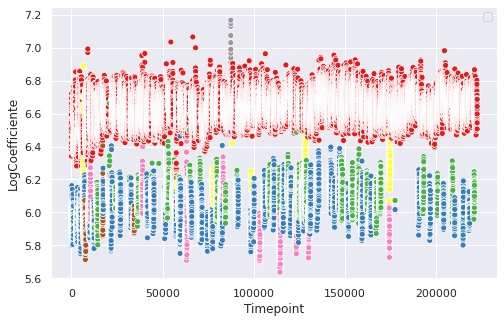

In [0]:
#Si rappresenta l'intera serie storica
sns.scatterplot(x=range(len(db)), y=np.log(db["Coefficiente"]),hue=db['Programma'],palette="Set1")
plt.legend('')
plt.ylabel('LogCoefficiente')
plt.ylim(5.6, 7.25)
plt.xlabel('Osservazioni')

È chiaro come la periodicità del valore del coefficiente non derivi da una correlazione temporale fra i valori stessi, bensì dall'ordine con cui si sceglie di effettuare le misurazioni sui diversi gruppi GP5, che, come si è visto in precedenza, hanno distribuzioni differenti.

NB: I colori delle classi sono riassegnati ad ogni plot. Nonostante i colori siano diversi, la classe più popolosa è con valore del coefficiente più elevato rimane sempre: `18_GP5_910_CW.DBF` (in rosso nel 2016, 2018, 2019 e in verde nel 2017).

##**Data scaling**

È necessario mappare le variabili fra 0 e 1.

In [0]:
scaler = MinMaxScaler()
vars_num = set(db_num.columns)
db_scaled = db
db_scaled[[i for i in vars_num]] = scaler.fit_transform(db_scaled[[k for k in vars_num]])
db_scaled.head(1)

,picco_pressione_velocita_1,Turno,picco_coppia_finale,picco_portata_velocita_1,Temperatura,media_pressione_velocita_1,media_coppia_finale,Data_ora,media_portata_velocita_a_regime,picco_pressione_velocita_a_regime,media_portata_velocita_1,picco_portata_velocita_a_regime,Programma,esito,media_pressione_velocita_a_regime,Coefficiente
0,0.455599,B,0.040291,0.335178,0.399076,0.470899,0.073801,2016-11-09 15:43:30,0.846723,0.7735,0.377995,0.837821,18_GP5_910_CW.DBF,PEZZO BUONO ...,0.773011,0.037621


In [0]:
#Esporta db scalato
db_scaled.to_csv("/content/DbScalato.csv")

##**Outliers univariati**



In [0]:
#Caricamente db scalato
db_scaled = pd.read_csv("/content/DbScalato.csv")
db_scaled.drop(['Unnamed: 0'], axis='columns', inplace=True)

Si analizzano i valori anomali della variabile target `Coefficiente`. Prima, però, è necessario verificare che la distribuzione scalata sia effettivamente normale, in modo da esser certi di poterli individuare sfruttando un cutoff sulla z-score, anziché usare il metodo non parametrico della distanza interquartile. Innanzitutto, si osserva la forma della distribuzione scalata e il rispettivo Quantile-Quantile Plot, con cui è possibile confrontare la variabile con una Normale teorica:

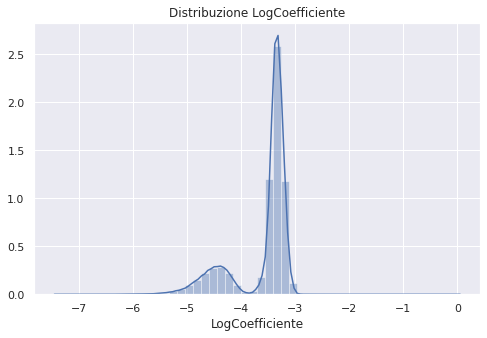

In [0]:
sns.distplot(np.log(db_scaled.Coefficiente[db_scaled.Coefficiente>0]))
plt.xlabel("LogCoefficiente")
plt.title("Distribuzione LogCoefficiente")
plt.show()

In [0]:
#Test di normalità Shapiro-Wilk
stat, p = shapiro(db_scaled.Coefficiente)
print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
	print('Sample looks Gaussian (fail to reject H0)')
else:
	print('Sample does not look Gaussian (reject H0)')

Statistics=0.810, p=0.000
Sample does not look Gaussian (reject H0)


In [0]:
def out_uni(y, type):
  Q1, Q3 = np.quantile(y,[0.25, 0.75])
  IQR = iqr(y)
  if type == "iqr":
    mask = (y < Q1 - 1.5 * IQR) | (y > Q3 + 1.5 * IQR)
  elif type == "zscore":
    mask = np.abs(zscore(y) > 3.5)
  idx = np.where(mask)
  return [i for i in idx[0]]

#Seleziona indici degli outliers
ind = out_uni(db_scaled.Coefficiente,type="iqr")

Si controlla se gli outliers si verificano in determinate condizioni: con un particolare programma, quando si presenta una determinata anomalia nella produzione del pezzo o durante determinati periodi.

In [0]:
db_out = db_scaled.iloc[ind][['Coefficiente','Programma','esito','Turno','Data_ora']]

print("Programmi: ",len(db_out.Programma.unique()))
print("Esiti: ",len(db_out.esito.unique()))
print("Turni: ",db_out.Turno.unique())

Programmi:  13
Esiti:  10
Turni:  ['B' 'C' 'A' nan]


In [0]:
#Data/mese
db_out['Anno'] = db_out.Data_ora.apply(anno)
db_out['Mese'] = db_out.Data_ora.apply(mese)
print("Anni: ",db_out.Anno.unique())
print("Mesi: ",db_out.Mese.unique())

Anni:  [2016 2017 2018 2019]
Mesi:  [11 12  9 10  5  6  7  8]


È possibile concludere che i valori anomali non dipendano da precise condizioni, né periodi.

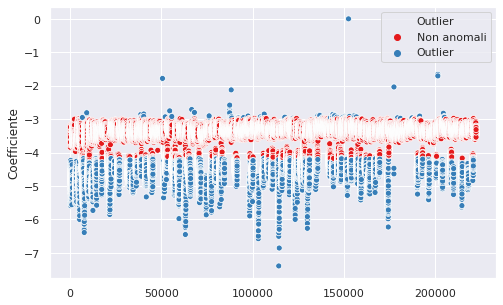

In [0]:
db_scaled['Outlier']="Non anomali"
db_scaled['Outlier'].loc[ind]="Outlier"
sns.scatterplot(x=range(len(db_scaled)),y=np.log(db_scaled.Coefficiente),hue=db_scaled.Outlier,palette="Set1")
db_scaled.drop(['Outlier'], axis='columns', inplace=True)

##[Novelty Detection](https://elearning.unimib.it/pluginfile.php/773771/mod_resource/content/1/IndLab2020_esercitazione_3_data_preprocessing.pdf)

- Misure [statiche](https://medium.com/learningdatascience/anomaly-detection-techniques-in-python-50f650c75aaf):
  1. Local Outlier Factor
  2. DBSCAN
  3. Elliptic Envelope
  4. One-Class Support Vector Machines
- Misure dinamiche:
  1. [HalfSpaceTrees](https://scikit-multiflow.github.io/scikit-multiflow/_autosummary/skmultiflow.anomaly_detection.HalfSpaceTrees.html)

In [0]:
#1.1 LOF

def LOF(x):
  lier_indicator = []
  lof = LocalOutlierFactor()
  c = lof.fit_predict(x)
  score = - lof.negative_outlier_factor_
  for k in score:
    if k > 1:
      lier_indicator.append("Outlier")
    elif (k > 1.1) | (k < 0.9):
      lier_indicator.append("Border")
    else:
      lier_indicator.append("Inlier")
  return lier_indicator

LOFoutliers = LOF(db_num)
db_num['LOFoutliers'] = LOFoutliers
print("Outlier:",len(db_num[db_num.LOFoutliers=="Outlier"])/len(db_num))
print("Border:",len(db_num[db_num.LOFoutliers=="Border"])/len(db_num))

Outlier: 0.7682412304153056
Border: 0.0


In [0]:
l = db_num[db_num.LOFoutliers=="Outlier"].index.tolist()
print(len(db.loc[[i for i in l]]['Programma'].unique()))
print(db.loc[[i for i in l]]['Turno'].unique())
print(len(db.loc[[i for i in l]]['esito'].unique()))

18
['B' 'C' 'A' nan]
12


Gli outlier multivariati individuati dal metodo `Local Outlier Factor` non si presentano in condizioni particolari di programma, turno o esito.

In [0]:
#1.2 DBSCAN
from sklearn.cluster import DBSCAN
from matplotlib import cm

outlier_detection = DBSCAN(eps = .2, metric="euclidean", min_samples = 5, n_jobs = -1)
clusters = outlier_detection.fit_predict(db_num)
clusters
#cmap = cm.get_cmap("Set1")
#db_num.plot.scatter(y='Coefficiente', c=clusters, cmap=cmap,colorbar = False)

In [0]:
#1.3 Elliptic Envelope
from sklearn.covariance import EllipticEnvelope
clf = EllipticEnvelope(contamination=.1,random_state=0)
clf.fit(df)
ee_scores = pd.Series(clf.decision_function(df)) 
ee_predict = clf.predict(df)
cmap=np.array(['white','red'])
plt.scatter(num.iloc[:,1],num.iloc[:,2],c='white',s=20,edgecolor='k')
plt.scatter(ee_anomalies.iloc[:,1],ee_anomalies.iloc[:,2],c='red')#,marker='x',s=100)
plt.title('Elliptic Envelope - Anomalies')
plt.xlabel('Income')
plt.ylabel('Spend_Score')

In [0]:
#1.4 One-Class Support Vector Machines
from sklearn import svm
clf=svm.OneClassSVM(nu=.2,kernel=’rbf’,gamma=.001)
clf.fit(df)
y_pred=clf.predict(df)
num.plot.scatter(x=’Income’,y=’Spend_Score’, c=y_pred, cmap=cmap,
 colorbar = False)
plt.title(‘One-Class SVM — Anomalies’)

##**Monitoring System**

[Progression Plot](https://pythonawesome.com/create-real-time-plots-in-jupyter-notebooks/)

[Plotly express](https://medium.com/plotly/introducing-plotly-express-808df010143d)

In [60]:
#Inizializzazione client
client = KafkaClient(hosts="127.0.0.1:9092")
#Selezione topic
topic = client.topics['test']
#Creazione di un simple consumer
consumer = topic.get_simple_consumer()
#Per ottenere solo gli ultimi messaggi si modifica il retention time (ora è 10 sec)
!kafka-topics --zookeeper localhost:2181 --alter --topic test --config retention.ms=10

         Going forward, please use kafka-configs.sh for this functionality
Updated config for topic "test".


In [104]:
#Stop
consumer.stop()
#Start
consumer.start()

Il ciclo termina per errore con l'invio da producer di qualsiasi messaggio che non sia un numero.

In [ ]:
#Identificazione degli outlier
def out_uni(distr,y):
    Q1, Q3 = np.quantile(distr,[0.25, 0.75])
    IQR = iqr(distr)
    if (y < Q1 - 1.5 * IQR):
        return "OUTLIER [<Q1]"
    elif (y > Q3 + 1.5 * IQR):
        return "OUTLIER [>Q3]"
    else:
        return ""

#Ciclo
values=[k for k in db.Coefficiente]
for message in consumer:
    if message is not None:
        v = float(message.value.decode("utf-8"))
        #Log
        print(datetime.datetime.now().time(),v,out_uni(values,v),"\n","--")
        values.append(v)

In [ ]:
#Plotly Express


<bw>
__________________________________________________________________________________________________________________________________________
<bw>

In [12]:
#Ricarico
#Caricamento db ridotto
db = pd.read_csv("/Users/riccardocervero/Desktop/DbRidotto.csv")
db.drop(['Unnamed: 0'], axis='columns', inplace=True)
categ = ['Turno','Programma','esito','Data_ora']
db_num = db.drop([i for i in categ], axis='columns')
len(db_num.columns)

12

**Prossime cose**:
0. Producer/Consumer diverso per sensore media_portata_velocità1
1. Far lampeggiare se media_portata_velocità1 < 50
2. [Dashboard](https://medium.com/plotly/introducing-plotly-express-808df010143d) o [JupyterLab Chart Editor](https://medium.com/plotly/introducing-plotly-express-808df010143d)